In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Settings ---
DATA_DIR = r"C:\Users\sandy\Downloads\Data"  # Path to your dataset directory
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Stage 1 class mapping
stage1_class_map = {
    'Non Demented': 'Non Demented',
    'Very mild Dementia': 'Demented',
    'Mild Dementia': 'Demented',
    'Moderate Dementia': 'Demented'
}

# --- 1. Load image paths and mapped labels (string labels) ---
def get_file_paths_and_labels(data_dir, stage1_map):
    file_paths = []
    labels = []
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                file_paths.append(os.path.join(class_path, img_file))
                labels.append(stage1_map[class_folder])
    return np.array(file_paths), np.array(labels)

file_paths, labels = get_file_paths_and_labels(DATA_DIR, stage1_class_map)
print("Labels distribution:", pd.Series(labels).value_counts())

# --- 2. Train/Val/Test split (with string labels) ---
X_trainval, X_test, y_trainval, y_test = train_test_split(
    file_paths, labels, test_size=0.15, stratify=labels, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=SEED)
# 0.1765 * 0.85 ≈ 0.15 total val

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# --- 3. Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'class': y_val}),
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

# --- 4. Compute class weights ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)
print("Class index mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# --- 5. Build EfficientNetB0 model ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# --- 6. Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('stage1_best_model.h5', monitor='val_loss', save_best_only=True)

# --- 7. Train model ---
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint]
)

# --- 8. Evaluate on test set ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


Labels distribution: Demented        19215
Non Demented    10614
Name: count, dtype: int64
Train: 20879, Val: 4475, Test: 4475
Found 20879 validated image filenames belonging to 2 classes.
Found 4475 validated image filenames belonging to 2 classes.
Found 4475 validated image filenames belonging to 2 classes.
Class weights: {0: 0.7762287158896573, 1: 1.4050471063257066}
Class index mapping: {'Demented': 0, 'Non Demented': 1}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

C:\Users\sandy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
653/653 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5042 - loss: 0.6990

653/653 ━━━━━━━━━━━━━━━━━━━━ 2059s 3s/step - accuracy: 0.5042 - loss: 0.6990 - val_accuracy: 0.3558 - val_loss: 0.7056
Epoch 2/30
551/653 ━━━━━━━━━━━━━━━━━━━━ 4:32 3s/step - accuracy: 0.5013 - loss: 0.6993

KeyboardInterrupt: 

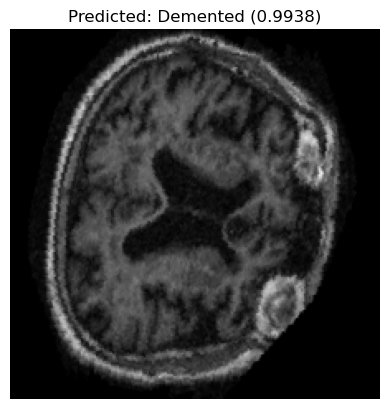

Predicted Class: Demented
Confidence Score: 0.9938


In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# === Constants (same as your config) ===
MODEL_PATH = r"C:\Users\sandy\Downloads\modelly.h5"
IMAGE_SIZE = (224, 224)  # Same as training image size
CLASS_NAMES = ['Non-Demented', 'Demented']

# === Load the trained model ===
binary_model = tf.keras.models.load_model(MODEL_PATH)

def preprocess_image(image_path):
    """
    Load an image from path and preprocess it:
    - Load and convert to RGB
    - Resize to IMAGE_SIZE
    - Convert to numpy array
    - Normalize pixels to [0,1]
    - Add batch dimension
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0  # Normalizing like your Rescaling layer
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dim (1, 224, 224, 3)
    return img_array, img

def predict_single_image(image_path):
    img_array, original_img = preprocess_image(image_path)
    
    prediction = binary_model.predict(img_array, verbose=0)
    predicted_class = int(prediction[0][0] > 0.5)
    confidence = prediction[0][0]
    predicted_label = CLASS_NAMES[predicted_class]

    # Display results
    plt.imshow(original_img)
    plt.title(f"Predicted: {predicted_label} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence Score: {confidence:.4f}")

# === Example usage ===
IMAGE_PATH = r"C:\Users\sandy\Downloads\correct_predictions\Non-Demented\img_16.png"  # change this path
predict_single_image(IMAGE_PATH)


Found 36000 files belonging to 2 classes.
Using 7200 files for validation.


C:\Users\sandy\AppData\Local\Temp\ipykernel_6600\809779905.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction > 0.5)
C:\Users\sandy\AppData\Local\Temp\ipykernel_6600\809779905.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_class = int(label.numpy())


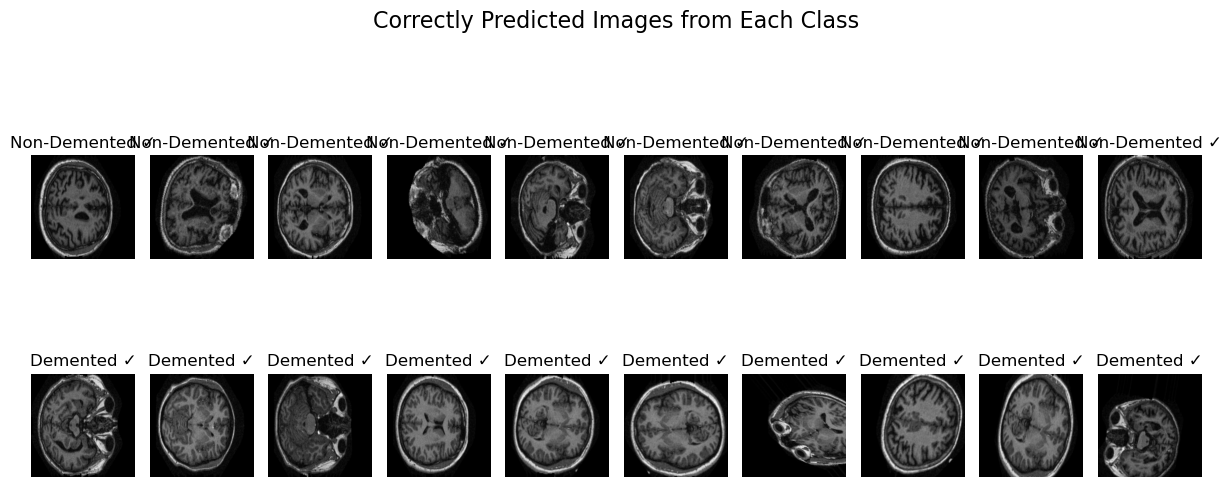

Predicted class for input image: Demented


C:\Users\sandy\AppData\Local\Temp\ipykernel_6600\809779905.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction > 0.5)


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# === Configs ===
BASE_DIR = r"C:\Users\sandy\Downloads\binary_balanced_augmenteddd"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
MODEL_PATH = r"C:\Users\sandy\Downloads\modelly.h5"

# === Load model (assumes binary_model is loaded elsewhere) ===
binary_model = tf.keras.models.load_model(MODEL_PATH)

# === Dataset loading ===
binary_val_dataset = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Optional: prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
binary_val_dataset = binary_val_dataset.prefetch(buffer_size=AUTOTUNE)

# === Visualization: Show correctly predicted images for each class ===
class_names = ['Non-Demented', 'Demented']
correct_images = {0: [], 1: []}  # 0: Non-Demented, 1: Demented
max_images_per_class = 10  # Number of correct samples to display per class

for image, label in binary_val_dataset.unbatch():
    img_array = tf.expand_dims(image, axis=0)  # Add batch dimension
    prediction = binary_model.predict(img_array, verbose=0)
    predicted_class = int(prediction > 0.5)
    true_class = int(label.numpy())

    if predicted_class == true_class and len(correct_images[true_class]) < max_images_per_class:
        correct_images[true_class].append((image, predicted_class))

    if all(len(correct_images[i]) >= max_images_per_class for i in (0, 1)):
        break

plt.figure(figsize=(12, 6))
for cls in [0, 1]:
    for i, (img, pred) in enumerate(correct_images[cls]):
        plt.subplot(2, max_images_per_class, cls * max_images_per_class + i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f"{class_names[cls]} ✓")
        plt.axis('off')

plt.suptitle("Correctly Predicted Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


# === Function to predict a single image from a file path ===
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = binary_model.predict(img_array, verbose=0)
    predicted_class = int(prediction > 0.5)

    return class_names[predicted_class]

# === Example usage ===
image_path = r"C:\Users\sandy\Downloads\correct_predictions\Non-Demented\img_15.png" # Change this to your image
predicted_label = predict_image(image_path)
print(f"Predicted class for input image: {predicted_label}")


Found 36000 files belonging to 2 classes.
Using 7200 files for validation.


C:\Users\sandy\AppData\Local\Temp\ipykernel_28308\2868181646.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction > 0.5)
C:\Users\sandy\AppData\Local\Temp\ipykernel_28308\2868181646.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_class = int(label.numpy())


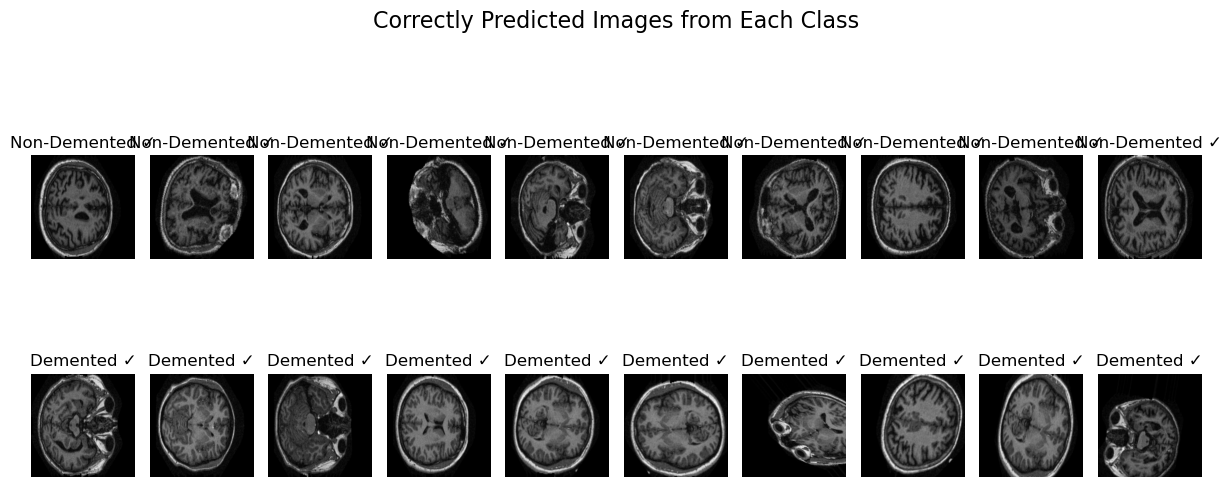

Predicted class for input image: Demented


C:\Users\sandy\AppData\Local\Temp\ipykernel_28308\2868181646.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction > 0.5)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# === Configs ===
BASE_DIR = r"C:\Users\sandy\Downloads\binary_balanced_augmenteddd"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
MODEL_PATH = r"C:\Users\sandy\Downloads\modelly.h5"

# === Load model ===
binary_model = tf.keras.models.load_model(MODEL_PATH)

# === Dataset loading ===
binary_val_dataset = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Optional: prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
binary_val_dataset = binary_val_dataset.prefetch(buffer_size=AUTOTUNE)

# === Visualization: Show correctly predicted images for each class ===
class_names = ['Non-Demented', 'Demented']
correct_images = {0: [], 1: []}
max_images_per_class = 10

for image, label in binary_val_dataset.unbatch():
    # IMPORTANT: Model includes a Rescaling layer, so no manual normalization here
    img_array = tf.expand_dims(image, axis=0)  # Add batch dimension
    prediction = binary_model.predict(img_array, verbose=0)
    predicted_class = int(prediction > 0.5)
    true_class = int(label.numpy())

    if predicted_class == true_class and len(correct_images[true_class]) < max_images_per_class:
        correct_images[true_class].append((image, predicted_class))

    if all(len(correct_images[i]) >= max_images_per_class for i in (0, 1)):
        break

plt.figure(figsize=(12, 6))
for cls in [0, 1]:
    for i, (img, pred) in enumerate(correct_images[cls]):
        plt.subplot(2, max_images_per_class, cls * max_images_per_class + i + 1)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f"{class_names[cls]} ✓")
        plt.axis('off')

plt.suptitle("Correctly Predicted Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


# === Function to predict a single image from a file path ===
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img)  # Keep pixel values in [0,255], dtype=uint8
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # DO NOT normalize manually since model has Rescaling layer
    prediction = binary_model.predict(img_array, verbose=0)
    predicted_class = int(prediction > 0.5)

    return class_names[predicted_class]

# === Example usage ===
image_path = r"C:\Users\sandy\Downloads\binary_balanced_augmenteddd\Non Demented\augmented_1006_OAS1_0167_MR1_mpr-1_124.png"
predicted_label = predict_image(image_path)
print(f"Predicted class for input image: {predicted_label}")


In [2]:
# === Function to predict a single image from a file path ===
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
IMAGE_SIZE = (224, 224)  # Replace with your model's expected input size
MODEL_PATH = r"C:\Users\sandy\Downloads\modelly.h5"
binary_model = tf.keras.models.load_model(MODEL_PATH)
class_names = ['Non-Demented', 'Demented']

def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img)  # Keep pixel values in [0,255], dtype=uint8
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # DO NOT normalize manually since model has Rescaling layer
    prediction = binary_model.predict(img_array, verbose=0)
    predicted_class = int(prediction > 0.5)

    return class_names[predicted_class]

# === Example usage ===
image_path = r"C:\Users\sandy\Downloads\Demo_Testing\Demented\img_14.png"
predicted_label = predict_image(image_path)
print(f"Predicted class for input image: {predicted_label}")

Predicted class for input image: Demented


C:\Users\sandy\AppData\Local\Temp\ipykernel_28308\4183825041.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction > 0.5)
